In [42]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [44]:
n = 100
time = np.arange(n)

# Спадний тренд з варіацією
bets_decreasing = np.random.poisson(lam=6 - np.linspace(1, 3, n//2), size=n//2)
noise_dec = np.random.normal(0, 2, n//2)
bets_decreasing = np.maximum(bets_decreasing + noise_dec, 1).astype(int)

# Зростаючий тренд з варіацією
bets_increasing = np.random.poisson(lam=5 + np.linspace(1, 3, n//2), size=n//2)
noise_inc = np.random.normal(0, 1, n//2)
bets_increasing = np.maximum(bets_increasing + noise_inc, 1).astype(int)

# Тепер навпаки: спочатку спадний, потім зростаючий
bets = np.concatenate([bets_decreasing, bets_increasing])
bets

array([ 4,  1,  6,  5,  2,  6,  2,  5,  5,  6,  4,  1,  5,  6,  2,  1,  4,
        3,  5,  6,  1,  2,  1,  3,  1,  4,  5,  2, 12,  1,  6,  6,  3,  3,
        6,  2,  5,  2,  1,  2,  7,  1,  4,  2,  3,  5,  3,  3,  1,  1,  6,
        7,  6,  8,  1,  4,  9,  6,  4,  6,  4,  8,  3,  5, 10, 10,  1,  1,
        3, 10,  4, 10,  8,  8,  4,  6, 10, 13, 10,  6,  8, 12, 10,  6,  6,
        7,  6,  8,  3,  3,  8,  9,  6,  8, 12,  9, 11,  8,  9,  8])

In [45]:
def calculate_interest(bets):
    cumulative = np.cumsum(bets)
    cum_vol_norm = (cumulative - cumulative.min()) / (cumulative.max() - cumulative.min() + 1e-9)
    time_norm = np.linspace(0, 1, len(cum_vol_norm)).reshape(-1, 1)
    ideal_line = time_norm.ravel()

    # --- інтегральний спосіб ---
    diff = cum_vol_norm - ideal_line
    interes_trapz = -np.trapz(diff, ideal_line)
    if np.isnan(interes_trapz) or interes_trapz is None:
        interes_trapz = 0.0

    # --- регресія ---
    model = LinearRegression().fit(time_norm, cum_vol_norm)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(time_norm, cum_vol_norm)

    # --- відхилення від ідеальної лінії (y = x) ---
    mse_vs_ideal = np.mean((cum_vol_norm - ideal_line) ** 2)

    return {
        "interes_trapz": interes_trapz,
        "slope": slope,
        "intercept": intercept,
        "r2": r2,
        "mse_vs_ideal": mse_vs_ideal
    }

res = calculate_interest(bets)
res

{'interes_trapz': 0.09110296826306216,
 'slope': 0.9501199141009107,
 'intercept': -0.0652518956308964,
 'r2': 0.9695958497776835,
 'mse_vs_ideal': 0.010752709535392351}

- interes_trapz = -0.0547

    Це площа між реальною кумулятивною кривою і ідеальною лінією (y=x).

        🔹 Знак показує, куди «завалюється» крива (вище чи нижче ідеалу).
        🔹 Чим більше за модулем значення — тим сильніше відхилення від рівномірного росту.

- slope = 1.042

    Нахил регресійної прямої. Ідеально мало би бути 1.

        🔹 Якщо більше 1 → ріст кумулятивної кривої швидший, ніж рівномірний.
        🔹 Якщо менше 1 → повільніший.

- intercept = 0.033

    Зсув на старті. Ідеально мало би бути 0.

        🔹 Позитивний — крива стартує «вище» ідеалу.
        🔹 Негативний — нижче.

- r2 = 0.986

    Наскільки добре лінійна регресія описує твою кумулятивну криву.
        
        🔹 Близьке до 1 → крива майже лінійна.
        🔹 Якщо сильно падає → є викривлення.

- mse_vs_ideal = 0.00436

    Середнє квадратичне відхилення від ідеальної прямої y=x.

        🔹 Чим ближче до 0 — тим «рівномірніше» розподілений твій об’єм ставок.

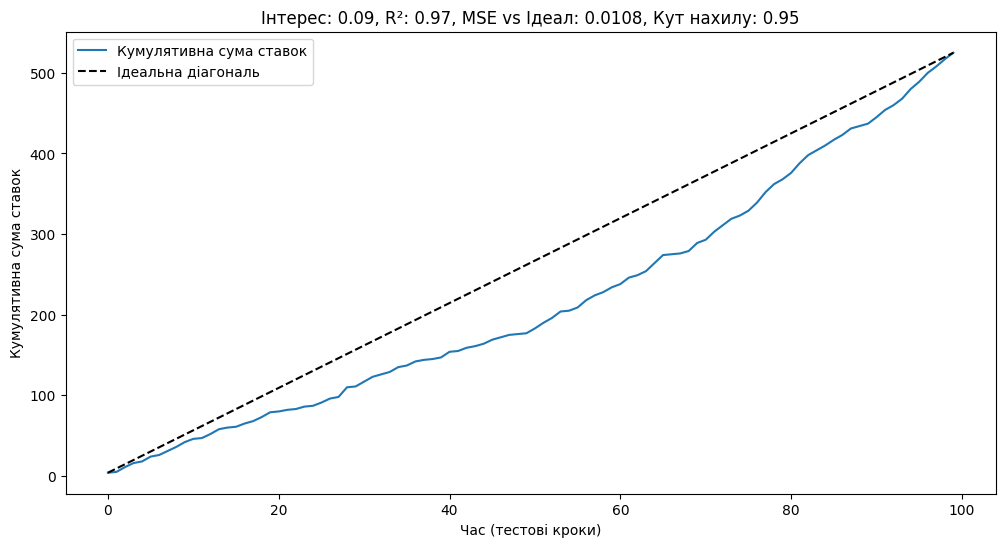

In [46]:
cumulative = np.cumsum(bets)

plt.figure(figsize=(12,6))
plt.plot(time, cumulative, label='Кумулятивна сума ставок')

plt.plot([time.min(), time.max()], [cumulative.min(), cumulative.max()], 
         'k--', label='Ідеальна діагональ')

plt.xlabel('Час (тестові кроки)')
plt.ylabel('Кумулятивна сума ставок')
plt.title(f'Інтерес: {res["interes_trapz"]:.2f}, R²: {res["r2"]:.2f}, MSE vs Ідеал: {res["mse_vs_ideal"]:.4f}, Кут нахилу: {res["slope"]:.2f}')
plt.legend()
plt.show()

/var/folders/7x/q4zhf1wx08z6l2f4bqz5b8dc0000gn/T/ipykernel_48327/2750529564.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(time, bets, cmap='coolwarm', label='Бонус (червоний - так)')


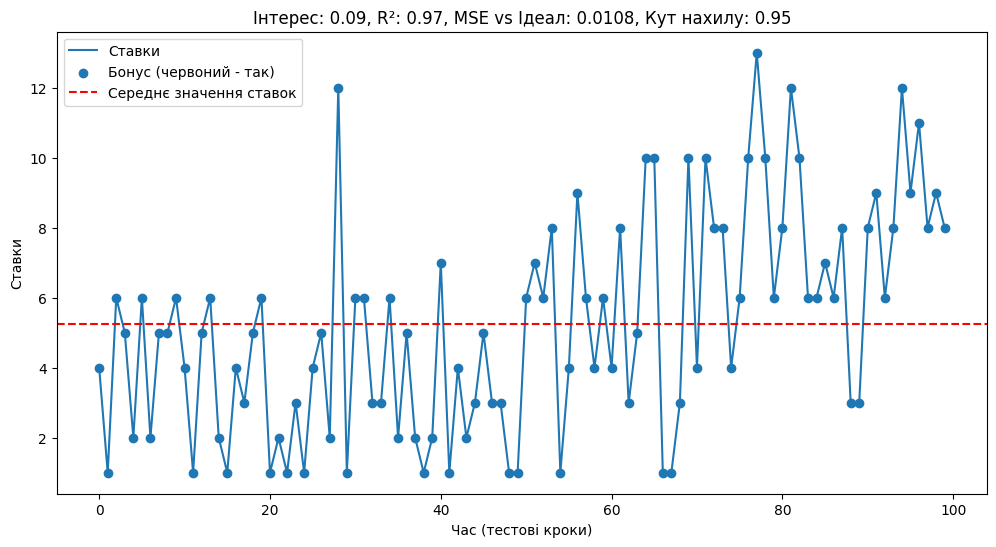

In [47]:
plt.figure(figsize=(12,6))
plt.plot(time, bets, label='Ставки')
plt.scatter(time, bets, cmap='coolwarm', label='Бонус (червоний - так)')

plt.axhline(y=bets.mean(), color='r', linestyle='--', label='Середнє значення ставок')

plt.xlabel('Час (тестові кроки)')
plt.ylabel('Ставки')
plt.title(f'Інтерес: {res["interes_trapz"]:.2f}, R²: {res["r2"]:.2f}, MSE vs Ідеал: {res["mse_vs_ideal"]:.4f}, Кут нахилу: {res["slope"]:.2f}')
plt.legend()
plt.show()